# Phase 3: Find Best Training Model
## Iteration 4: Fine tune best model.
### Import Libraries and Scripts

In [1]:
# import functions and classes for model
from Utils.preporcessing_utils import data_loading 
from Utils.preporcessing_utils import labels_encoding
from Utils.preporcessing_utils import split_data
from Utils.preporcessing_utils import image_iterators 
from Utils.evaluation_utils import Evaluation 

2025-09-17 16:17:45.830926: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 16:17:46.901082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758140267.111251  116982 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758140267.194772  116982 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-17 16:17:48.258721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [28]:
import numpy as np
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from tensorflow import keras

### Data Preparation and Basic Preprocessing

In [3]:
# Loads data
train_df, test_df = data_loading("train_full.csv", "test_full.csv")

In [4]:
# Create dataframe and transform(encodes) pathology labels
train_df, test_df = labels_encoding(train_df, test_df)

In [5]:
train_df.columns

Index(['image_id', 'image_type', 'image_path', 'series_uid', 'subject_id',
       'study_uid', 'breast_density', 'breast_side', 'image_view',
       'abnormality_type', 'pathology', 'split', 'label'],
      dtype='object')

In [6]:
# Split data
train_data, val_data, test_data = split_data(train_df, test_df, 0.11)

Train set: 1889 cases, 70.35 %
Validation set: 234 cases, 8.72 %
Test set: 562 cases, 20.93 %


In [7]:
print("Total taining samples:", len(train_data["label"]))
print("Positive labels:", len(train_data["label"][train_data["label"] == 1]))
print("Ratio: ", len(train_data["label"][train_data["label"] == 1])/len(train_data["label"]))

Total taining samples: 1889
Positive labels: 977
Ratio:  0.517204870301747


In [16]:
print("Total validation samples:", len(val_data["label"]))
print("Positive labels:", len(val_data["label"][val_data["label"] == 1]))
print("Ratio: ", len(val_data["label"][val_data["label"] == 1])/len(val_data["label"]))

Total validation samples: 234
Positive labels: 121
Ratio:  0.5170940170940171


In [17]:
print("Total testing samples:", len(test_data["label"]))
print("Positive labels:", len(test_data["label"][test_data["label"] == 1]))
print("Ratio: ", len(test_data["label"][test_data["label"] == 1])/len(test_data["label"]))

Total testing samples: 562
Positive labels: 260
Ratio:  0.4626334519572954


In [8]:
# Baseline No Preprocessing Techniques Only Resizing
baseline_techniques = {
    "Baseline Basic Preporcessing":{
         'apply_background_removal': False,
         'apply_crop': False,
         'apply_noise_reduction': False,
         'apply_contrast_enhancement': False,
         'apply_edge_enhancement': False,
         'apply_lbp_texturizer': False
    }
}

In [9]:
# Create image iterators with preprocessing function for each set of preprocessing techniques 
train_generator, val_generator, test_generator = image_iterators((train_data, val_data, test_data),
                                                                    with_preprocess=False,
                                                                    is_resnet_vgg=True,
                                                                    preprocessing_techniques_name="Baseline Basic Preporcessing",
                                                                    preprocessing_techniques=baseline_techniques["Baseline Basic Preporcessing"],
                                                                    image_dir="Preprocessed_Images/"
                                                                  )

I0000 00:00:1758140375.338059  116982 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [10]:
# get y_labels
y_true = test_data["label"]

### Load Model 

In [11]:
# Load model saved locally
model_name = "Models/Iteration4/vgg16:10_-_baseline_basic_preporcessing_-_(denseu=256,_dropout=0.2,_layer=256).keras"
vgg_model = keras.models.load_model(model_name)

In [12]:
# get model's prediction probabilities
y_pred_prob = vgg_model.predict(test_generator)

I0000 00:00:1758140381.268743  117146 service.cc:148] XLA service 0x7a732c004290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758140381.269403  117146 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-09-17 16:19:41.378285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758140381.492213  117146 cuda_dnn.cc:529] Loaded cuDNN version 90501


 3/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

I0000 00:00:1758140389.182291  117146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 320ms/step


### Calculate Evaluation Metrics

In [19]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]
print("Best threshold:", best_threshold)

Best threshold: 4.421951e-06


In [20]:
y_pred = (y_pred_prob >= best_threshold).astype(int)

In [21]:
# get metrics 
ev_metrics = Evaluation(vgg_model)

In [14]:
metrics = ev_metrics.calculate_metrics(y_true, y_pred_prob)
metrics

{'confusion_matrix': array([[146, 156],
        [ 54, 206]]),
 'accuracy': 0.6263345195729537,
 'precision': 0.569060773480663,
 'recall': 0.7923076923076923,
 'f1_score': 0.662379421221865,
 'roc_auc': 0.7030056036678554,
 'specificity': np.float64(0.48344370860927155),
 'fpr': np.float64(0.5165562913907285),
 'fnr': np.float64(0.2076923076923077)}

In [15]:
metrics2 = ev_metrics.calculate_metrics(y_true, y_pred_prob, threshold=0.79521376)
metrics2

{'confusion_matrix': array([[202, 100],
        [ 88, 172]]),
 'accuracy': 0.6654804270462633,
 'precision': 0.6323529411764706,
 'recall': 0.6615384615384615,
 'f1_score': 0.6466165413533834,
 'roc_auc': 0.7030056036678554,
 'specificity': np.float64(0.6688741721854304),
 'fpr': np.float64(0.33112582781456956),
 'fnr': np.float64(0.3384615384615385)}

In [36]:
# source https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
vgg_precision, vgg_recall, vgg_thresholds = precision_recall_curve(y_true, y_pred_prob)
vgg_f1 = (2 * vgg_precision * vgg_recall) / (vgg_precision + vgg_recall)
best_f1 = argmax(vgg_f1)
print("Best threshold", vgg_thresholds[best_f1])
print("Best balanced Recall=%f and Precision=%f" % (vgg_recall[best_f1], vgg_precision[best_f1]))

Best threshold 0.38427544
Best balanced Recall=0.826923 and Precision=0.567282


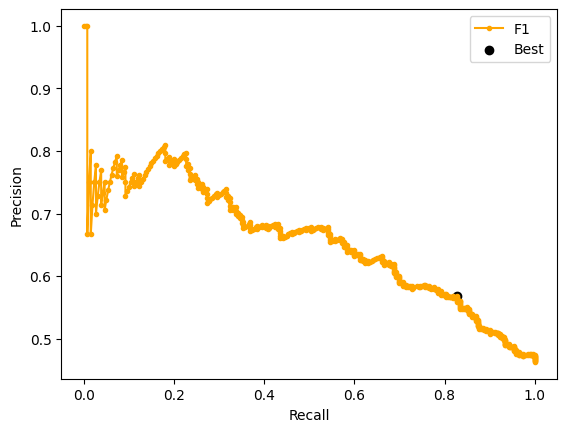

In [33]:
plt.plot(vgg_recall, vgg_precision, marker='.', label='F1',  color='orange')
plt.scatter(vgg_recall[best_f1], vgg_precision[best_f1], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
pyplot.legend()
plt.show()

In [45]:
metrics2 = ev_metrics.calculate_metrics(y_true, y_pred_prob, threshold=0.38427544)
metrics2

{'confusion_matrix': array([[138, 164],
        [ 45, 215]]),
 'accuracy': 0.6281138790035588,
 'precision': 0.5672823218997362,
 'recall': 0.8269230769230769,
 'f1_score': 0.672926447574335,
 'roc_auc': 0.7030056036678554,
 'specificity': np.float64(0.45695364238410596),
 'fpr': np.float64(0.543046357615894),
 'fnr': np.float64(0.17307692307692307)}